# Libraries

In cell below run <kbd>⇧ Shift</kbd>+<kbd>↵ Enter</kbd> in order to load libraries for this session

In [400]:
# The following loads in the major numerical and plotting libraries for python in a notebook
%pylab inline

# Load the probabilistic programming language pymc3
import pymc3 as pm
# import class for constructing random walks
from pymc3.distributions.timeseries import GaussianRandomWalk
import theano.tensor as tt


#import some special methods
from scipy.special import logit,expit
import scipy.stats as stats

# set some plotting parameters to create ggplot-style plots
import seaborn as sns
import matplotlib as mpl
sns.set_context(context='talk',font_scale=1.5)
plt.style.use('ggplot')
mpl.rcParams['axes.labelsize'] = 24

#interactive plotting tools
from ipywidgets import interactive

Populating the interactive namespace from numpy and matplotlib


# Background

The model makes use of a Bayesian analysis framework for a number of reasons

0. Bayesian analysis is __generative__. 

    This means that we're able to *re-create* our data multiple times through the Bayesian posterior. These multiple data-sets can then be used to build up an understanding of uncertainty.
    
0. It allows us to incorporate __prior knowledge__ of parameters.

    We can introduce literature-based estimates or expert opinion for things like overdose rate or prevalence of opioid use disorder. These priors can then be updated from data we present the model, however if the data is not informative of a given parameter, then at least we have the prior to fall back on. This is especially useful when dealing with possibly limited data.
    
0. We can incorporate __model structure__.
    
    Most Bayesian models can be written out like a recipe for how we believe our data is being generated. This allows us to incorporate not only processes driving what we're interested in (e.g. illicit opioid-use), but also processes that might bias the data (e.g. systematic under-reporting of overdoses).
    
0. We can incorporate multiple __data sources__.

    Similar to how we can factor in biases due to reporting of data, we can also incorporate how we believe the data should look. e.g. if there are a cluster of overdose cases that mean some months experience many more overdoses than in others then we could explcitly model the clustering effect of these cases (using a [negative-binomial](https://en.wikipedia.org/wiki/Negative_binomial_distribution) for example). In a standard logistic regression we may have to re-scale overdoses to deal with overly-dispersed data, but a Bayesian analysis allows us to be more explicit and transparent where the data came from and how it was generated.
    
Of course all analysis methods have their caveats and their limitations and Bayesian analysis is no exception. One tricky aspect can be in the actual fitting of data itself (drawing samples from the posterior in Bayesian nomenclature). Often its difficult to know if you have genuine independent samples from the posterior or not and many methods exist in order to test this. Approximate methods also exist for drawing from the posterior, but these methods may shrink the true uncertainty or provide a poor approximation when there is multi-modality in the posterior or exchangeability of parameters.

For more information see the book: [Gelman, Andrew, et al. Bayesian data analysis. 2013.](http://www.stat.columbia.edu/~gelman/book/)

## Motivating example

Start with a simple data-generating process. Imagine there are $N$ individuals, and in a given month anyone of them has an equal probability of experiencing an overdose at prevalence $p$. 

Begin by fixing $N = 10000$, and $p = 0.01$ (i.e. ten-thousand people each have a 1% chance of experiencing an overdose). The number of overdoses in a month $x$, is drawn from a binomial distribution,

$$ x \sim \text{Bin}(N,p)$$

Code to generate 1000 samples of this process is given below,


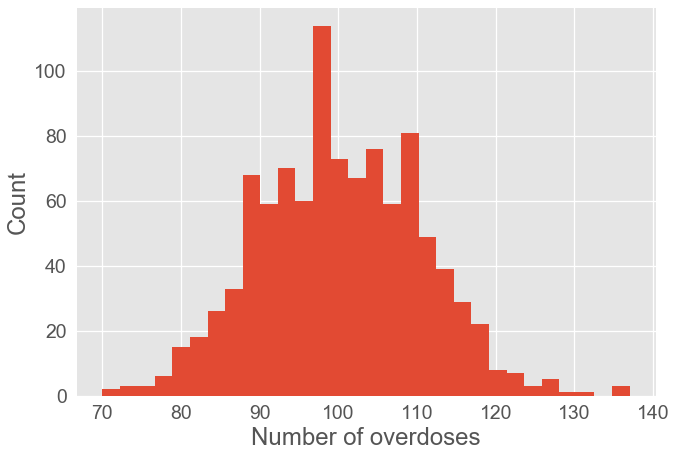

In [191]:
# define parameters
N,p = 10000,0.01

# perform draw
x = np.random.binomial(N,p,size=1000)

# plot histogram (add semi-colons to plt commands to suppress output)
plt.figure();
plt.hist(x,bins=30);
plt.xlabel('Number of overdoses');
plt.ylabel('Count');

### Hints

Use <kbd>↹ Tab</kbd> for auto-complete (helpful if can't remember exact commands). Use <kbd>⇧ Shift</kbd>+<kbd>↹ Tab</kbd> in order to view the doc-string for a particular method (helpful to see what method does and what input it takes).

### Adding in time

Instead of having a process that's being generated for just a given month, imagine instead we want to generate the process over a number of months. Draw samples of the number of overdoses for a year using the following,

In [213]:
# define parameters
N,p = 10000,0.01

# define number of months and number of samples
n_months = 12
n_samples = 1000

# generate data
x = np.random.binomial(N,p,size=(n_samples,n_months))

# check the shape of the data generated
print('Data generated is a {} by {} array'.format(*x.shape))

Data generated is a 1000 by 12 array


### Stylistic point

Define a method to create a plot of the time-series data. For the method we use the [numpy docstring](https://numpydoc.readthedocs.io/en/latest/format.html). This provides a consistent way of documenting methods and makes it easier to use automatic documentation such as [sphinx](http://www.sphinx-doc.org/en/master/).

In [216]:
def plot_data_timeseries(ys, xs=None,xlabel='Month',ylabel='Overdoses'):
    '''
    Plot 95 percentiles and interquartile range draws of time series data
    
    Parameters
    ----------
    
    ys : numpy array
        data to plot. In shape format (sample,time)
    x : numpy array
        1D array same size as ys 0 axis. Represents time-points
    xlabel : string
    ylabel : string
        
    Returns
    -------
    
    None
    
    '''
    color = '#E24A33'
    if xs is None:
        xs = np.arange(1,ys.shape[1]+1)
        
    plt.figure();
    lc,liqr,m,uiqr,uc = np.percentile(ys,[2.5,25.,50.,75.,97.5],axis=0);
    plt.fill_between(xs,lc,uc,alpha=0.25,color=color);
    plt.fill_between(xs,liqr,uiqr,alpha=0.25,color=color);
    plt.plot(xs,m,color=color);
    plt.xlabel(xlabel); plt.ylabel(ylabel);

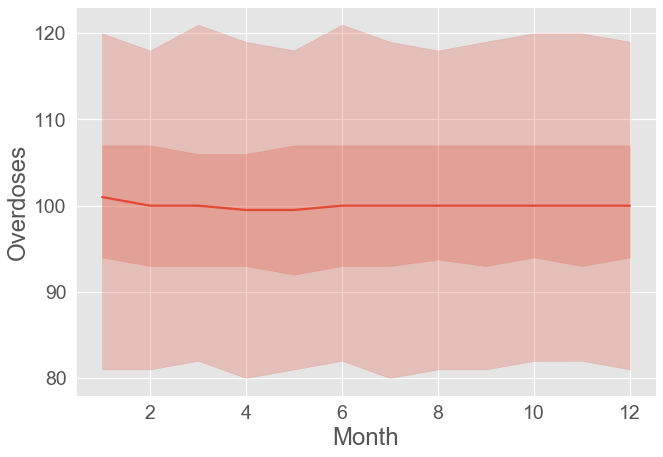

In [217]:
plot_data_timeseries(x)

## Adding in parameter uncertainty

It isn't just the number of overdoses that we may be uncertain about. We could also be uncertain about the underlying parameters as well. For our data-generating process we have point values for the size of the population $N$ and the prevalence of overdoses $p$. 

Let's assume our uncertainty in the size of the population is normally-distributed with mean 10000 and variance 1000 so,
$$N \sim N(10000,1000).$$

Prevalence of an overdose also has uncertainty associated with it. We can use the Beta distribution to characterise this. Imagine we had prior data for 100 individuals where 1 of them overdosed in a month. We can use an interpretation of the Beta distribution to characterise the uncertainty as,
$$p \sim B(\alpha,\beta).$$
where $\alpha = 1$ and is the number of overdoses (called successes in statistical literature), and $\beta = 99$, which is the number of non-overdoses (failures). We can create a method for our data generating process.

__Programming Notes:__ Here we use [broadcasting](https://docs.scipy.org/doc/numpy-1.15.0/user/basics.broadcasting.html) to replicate an array along a given axis. This allows us to not use a for loop and speeds up computation significantly. We also use a python [dictionary](https://docs.python.org/2/tutorial/datastructures.html#dictionaries) to return data, which helps to ensure we use the right variable in when analysing the data-generating process.


In [218]:
def overdose_generation():
    '''Create overdose samples for data-generating process.
    
    The population N has uncertainty and is drawn from a normal distribution. 
    The prevalence of overdoses in a given month is p and is drawn from a beta distribution.
    
    Parameters
    ----------
    None
    
    Returns
    -------
    dictionary
        Data generated for N,p, and x.
    '''
    
    # define number of months and number of samples
    n_months = 12
    n_samples = 1000
    
    #define prior for population size
    N_mean,N_var = 10000,1000
    # add singleton dimension to broadcast and convert into integer.
    N = np.random.normal(loc=N_mean,scale=np.sqrt(N_var),size=(n_samples,1)).astype(int) 
    
    #define prior for probability of an overdose
    p_alpha,p_beta = 1,99
    p = np.random.beta(p_alpha,p_beta,size=(n_samples,1))
    
    # generate data
    x = np.random.binomial(N,p,size=(n_samples,n_months))
    
    return {'N': N.flatten(), 'p': p.flatten(), 'x': x }

In [219]:
# create data
data = overdose_generation()

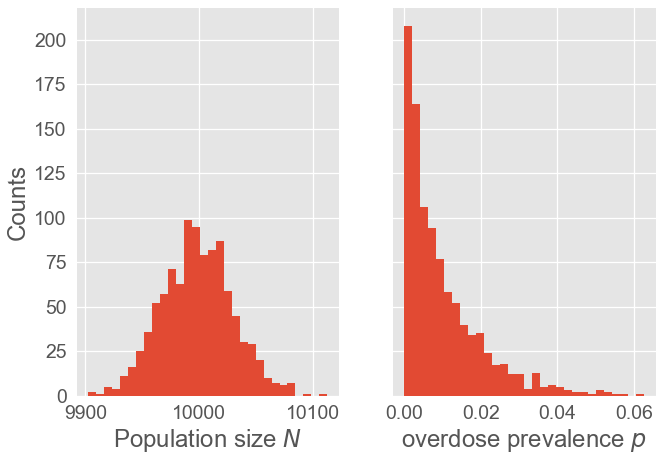

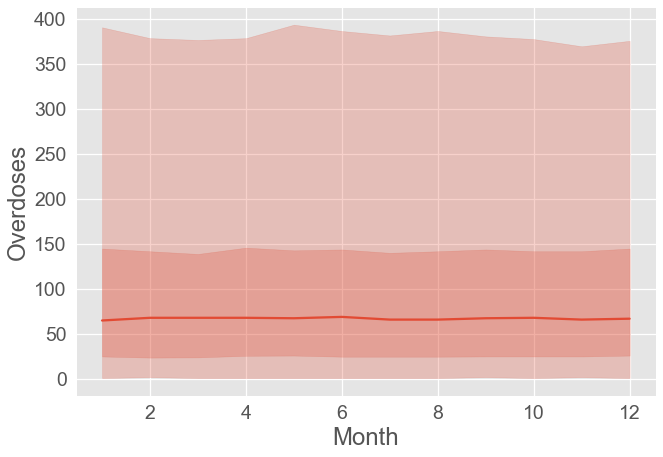

In [220]:
# plot data
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1.hist(data['N'],bins=30);
ax1.set_ylabel('Counts');
ax1.set_xlabel('Population size $N$');

ax2.hist(data['p'],bins=30);
ax2.set_xlabel('overdose prevalence $p$');

plot_data_timeseries(data['x'])

### Incorporating uncertainty in time

As a final step let's imagine that the prevalence of overdoses can vary in time. We can assume that the prevalence of an overdose is only dependent on the overdoses in the previous month and there is a general increasing trend. The simplest way to incorporate this is to first define a random walk with drift, $w_t$. Each time-step can be normally distributed around the previous time-step with variance $\sigma_w^2$ and a drift $\mu_w$,

$$w_t \sim N(w_{t-1} + \mu_w,\sigma_w^2)$$

or alternatively,
$$w_t \sim w_{t-1} + N(\mu_w,\sigma_w^2)$$

Some examples are plotted below,

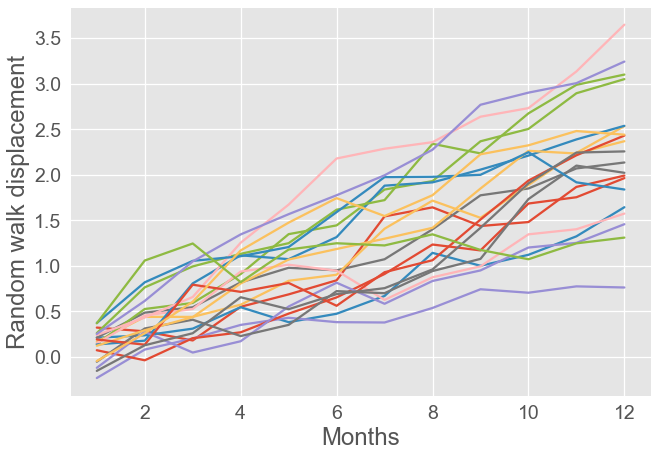

In [223]:
# time-points and samples
n_months,n_samples = 12,20

# define drift and variance
mu_w,sigma_w = 0.2,0.2

# sample errors
es = np.random.normal(loc=mu_w,scale=sigma_w,size=(n_samples,n_months))


ws = np.cumsum(es,axis=1).swapaxes(0,1)

plt.plot(np.arange(1,n_months+1),ws);
plt.xlabel('Months'); plt.ylabel('Random walk displacement');


In order to convert the random-walk $w_t$ into a probability $p_t$, we can transform it using the inverse-logit function,
$$p_t = \text{logit}^{-1}(w_t) = \frac{1}{1 + \exp(-w_t)}$$

Let's turn this into a method and plot some samples below,

In [226]:
def random_walk_prevalence(mu,sigma,initial_prevalence=0.01,shape=None):
    '''Create a random walk prevalence process with drift mu and variance sigma
    
    Parameters
    ----------
    mu : float
        drift of random walk in invlogit space
    sigma : float
        standard deviation of random walk in invlogit space
    shape : list
        shape of random walk in format (n_months,n_samples)
    
    Returns
    -------
    numpy array
        Samples of random walk process with shape (n_month,n_samples)
    
    '''
    
    # time-points and samples
    n_samples,n_months = shape


    # sample errors
    es = np.random.normal(loc=mu,scale=sigma,size=(n_samples,n_months))

    # create random walks with starting point equivalent to when prevalence is 0.01
    ws = logit(initial_prevalence) + np.cumsum(es,axis=1)

    # convert random walk into probability
    ps = expit(ws)
    
    return ps



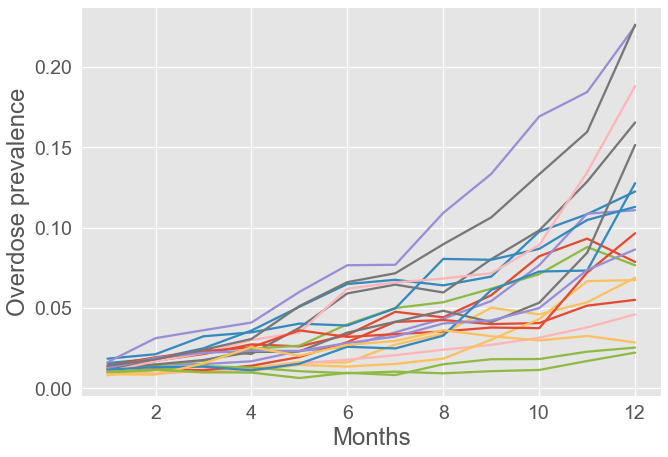

In [227]:
#define time-points and sample size
n_months,n_samples = 12,20

#generate samples
ps = random_walk_prevalence(0.2,0.2,shape=(n_samples,n_months)).swapaxes(0,1)

# plot samples
plt.plot(np.arange(1,n_months+1),ps);
plt.xlabel('Months'); plt.ylabel('Overdose prevalence');

We can now adapt the `overdose_generation` method above to include a random-walk overdose prevalence as opposed to a fixed prevalence

In [228]:
def randomwalk_overdose_generation():
    '''Create overdose samples for data-generating process, where overdoses are a random walk in inverse logit space.
    
    The population N has uncertainty and is drawn from a normal distribution. 
    The prevalence of overdoses in a given month is p and is drawn from a beta distribution.
    
    Parameters
    ----------
    None
    
    Returns
    -------
    dictionary
        Data generated for N,p, and x.
    '''
    
    # define number of months and number of samples
    n_months = 12
    n_samples = 1000
    
    #define prior for population size
    N_mean,N_var = 10000,1000
    # add singleton dimension to broadcast and convert into integer.
    N = np.random.normal(loc=N_mean,scale=np.sqrt(N_var),size=(n_samples,1)).astype(int) 
    
    # define prior for probability of an overdose
    ## define drift and variance
    mu_w,sigma_w = 0.2,0.2
    p = random_walk_prevalence(mu_w,sigma_w,shape=(n_samples,n_months))
    
    # generate data
    x = np.random.binomial(N,p,size=(n_samples,n_months))
    
    return {'N': N.flatten(), 'p': p, 'x': x }

In [229]:
# create data
data = randomwalk_overdose_generation()

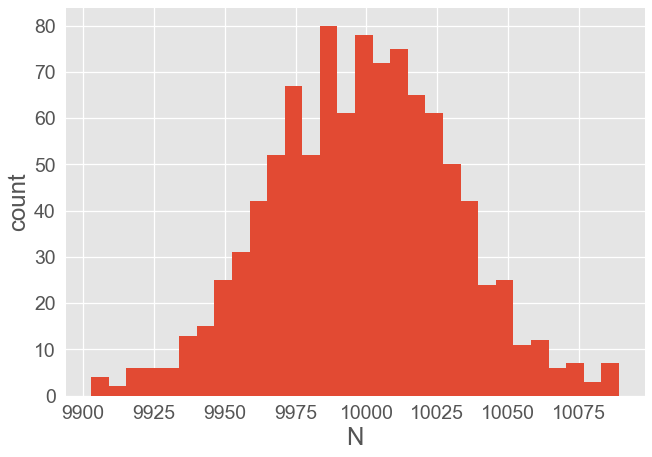

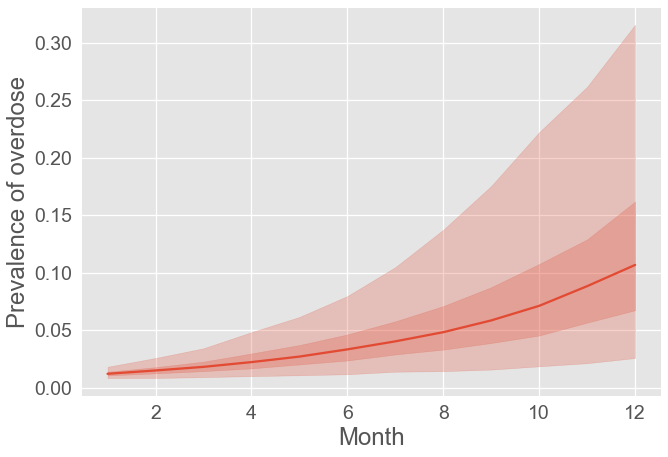

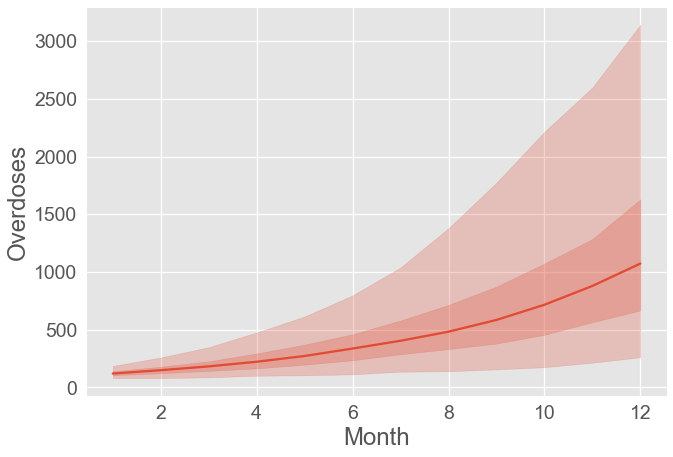

In [230]:
# plot data
plt.figure();
plt.hist(data['N'],bins=30);
plt.xlabel('N'); plt.ylabel('count');

plot_data_timeseries(data['p'],ylabel='Prevalence of overdose')

plot_data_timeseries(data['x'])

### Final steps

We've built up a data-generating model for a fixed population, with uncertainty experiencing overdoses that are binomially-distributed according to a time-varying process. This generation of data that is only  dependent on some hyper-parameters is known as the prior predictive check. It states what the model determines the process should look like before being exposed to data. To be fully Bayesian, we would have to estimate what each of these hyper-parameters should be, either through literature estimate or expert opinion. 

Re-define the method so that we can input the hyper-parameters and explore how this impacts the prior predictive check below.

In [231]:
def randomwalk_overdose_generation(N_mean = 10000, N_var = 1000, mu_w = 0.2,
                                   sigma_w = 0.2, n_months=12,n_samples=1000):
    '''Create overdose samples for data-generating process, where overdoses are a random walk in inverse logit space.
    
    The population N has uncertainty and is drawn from a normal distribution. 
    The prevalence of overdoses in a given month is p and is drawn from a beta distribution.
    
    Parameters
    ----------
    N_mean : float
        mean of population size
    N_var : float
        variance of population size
    mu_w : float
        drift of random walk in logit space
    sigma_w : float
        variance of random walk in logit space
    n_months : int
        number of months to simulate across
    n_samples : int
        number of samples to generate
    
    Returns
    -------
    dictionary
        Data generated for N,p, and x
    '''
    
    #define prior for population size
    N = np.random.normal(loc=N_mean,scale=np.sqrt(N_var),size=(n_samples,1)).astype(int) 
    
    # define prior for probability of an overdose
    p = random_walk_prevalence(mu_w,sigma_w,shape=(n_samples,n_months))
    
    # generate data
    x = np.random.binomial(N,p,size=(n_samples,n_months))
    
    return {'N': N.flatten(), 'p': p, 'x': x }

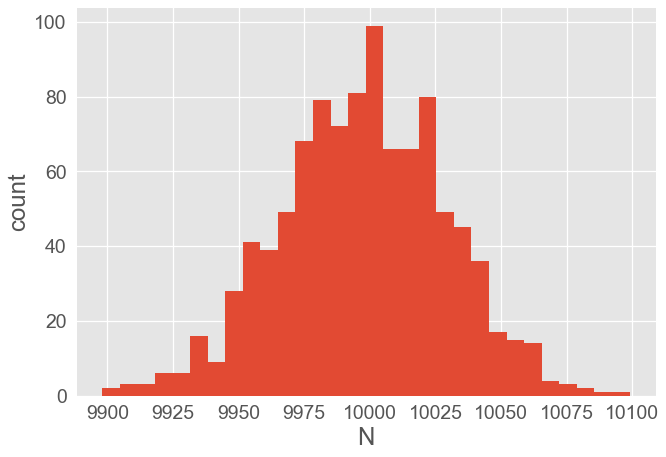

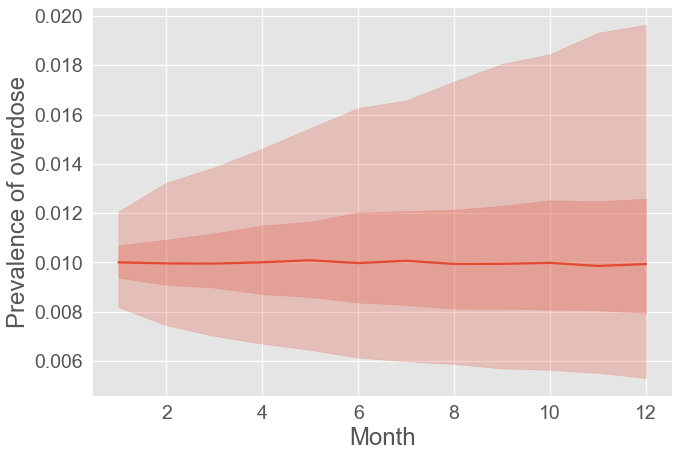

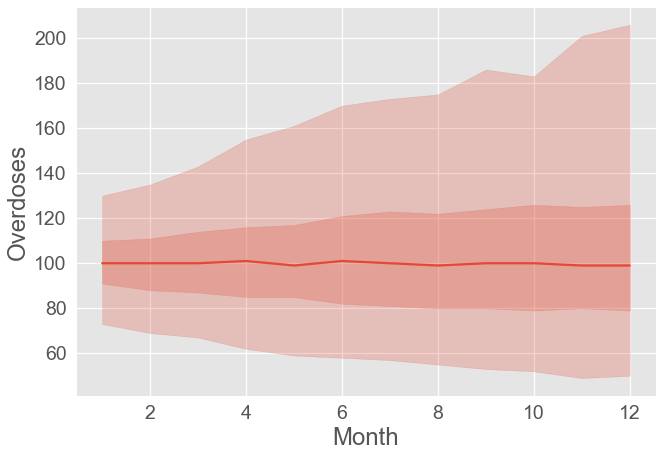

In [260]:
# create data
data = randomwalk_overdose_generation(N_mean = 10000, N_var = 1000, mu_w = 0.0,sigma_w = 0.1)

# plot data
plt.figure();
plt.hist(data['N'],bins=30);
plt.xlabel('N'); plt.ylabel('count');

plot_data_timeseries(data['p'],ylabel='Prevalence of overdose')

plot_data_timeseries(data['x'])

# Bayesian inference

![neon sign of Bayes' rule](https://upload.wikimedia.org/wikipedia/commons/thumb/1/18/Bayes%27_Theorem_MMB_01.jpg/640px-Bayes%27_Theorem_MMB_01.jpg)

A prior model generates uncertainty of an outcome based on a number of parameters. In the example above the parameters were the drift $\mu_w$ and variance $\sigma_w^2$ of the random walk process as well as the population size mean $\mu_N$ and variance of the population $\sigma_N^2$. There are also the latent random variables for the random walk process $w_t$, which are not directly observed. 

In Bayesian terminology, we combine together the parameters into one vector called $\theta$. e.g. for our example $\theta = (N,w_1,\ldots,w_{12})$ (All $w_t$ are also included in the prior as latent random variables). As our data-generating process is composed entirely of random variables, we can use these to build a probability of observing each parameter. For example, since $N \sim N(\mu_w,\sigma_w^2)$, we may write down the probability of observing the value $n$ for the population as,

$$P(N = n) = \frac{1}{\sqrt{2\pi \sigma_N^2}} \exp \left( \frac{1}{2\sigma_N^2}(n - \mu_N)^2 \right).$$

The exact form doesn't matter too much for our example as we rarely have to deal with any of the formulae explictly. A probability of observing a collection of parameters $P(\Theta = \theta)$ can then be composed as an independent product from each parameter (sometimes the prior is refered to as $\pi$ because statisticians and mathematicians refuse to use roman characters for anything).

The goal of Bayesian inference is to find the probability of a set of parameters given some data. Normally we can write down the likelihood of observing some data $D$ given a set of parameters $\theta$. In the above example this would be a binomial probability, as that's what we used to generate the number of overdoses. Normally the likelihood is written as $P(D | \theta)$ (the probability of observing the data given the model parameters). The posterior is then written as $P( \theta | D)$ (the probability of observing the parameters given the data). The posterior can be written in terms of the likelihood using Bayes' rule,

$$ P(\theta | D) = \frac{P(D | \theta) P(\theta)}{P(D)} $$

In order to do this we had to define a probability of observing the data $P(D)$. This is tricky to define, the important thing to note is that the posterior is proportional to both the likelihood and the prior,

$$ P(\theta | D) \propto P(D | \theta) P(\theta) $$

## Simple Bayesian inference example

Let's simplify the model above so that we only have a fixed probability of an overdose in a given month $p$. Let's imagine that we believe the probability is small (close to 0.01), but we're quite unsure about this. We fix the beta parameters $\alpha = 0.1, \beta = 0.99$ to reflect this.  We assume we know the population is exactly $N= 10000$ (really unreasonable, but this is just an illustrative example). We also observe three months of data $D = (40, 50, 51)$.

The prior is the probability of overdose prevalence $p$, 

$$P(\theta) = P(p) \propto p^\alpha(1-p)^\beta.$$

The likelihood is an independent binomial probability for each data-point,

$$P(D | \theta) \propto \prod_{i=1}^{i=3} p^{D_i}(1-p)^{N-D_i}.$$

$$ P(\theta | D) \propto p^{\alpha + \sum D_i}(1-p)^{\beta + 3N - \sum D_i}.$$

In [206]:
# define data
D = np.array([40,50,51])

# generate linearly spaced points over support of prior
xs = np.linspace(0,0.02,num=1000)

# define hyper-parameters
a, b = 1, 99
#generate pdf of prior
pdf_prior = stats.beta(a,b).pdf(xs)

a_post = a + D.sum()
b_post = b + D.size*N - D.sum()

pdf_post = stats.beta(a_post,b_post).pdf(xs)


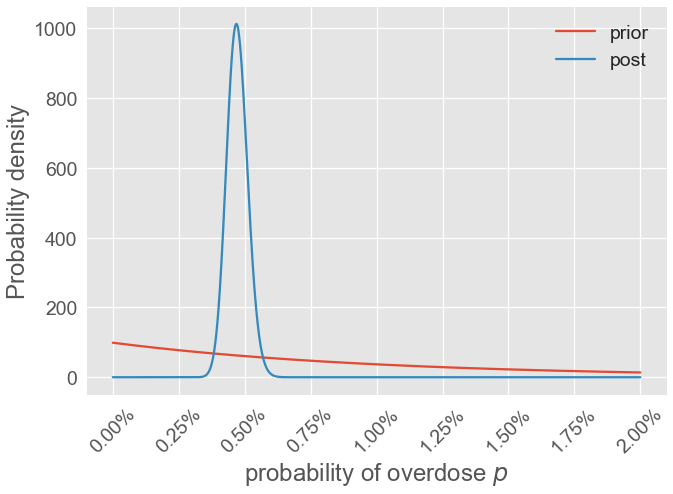

In [207]:
# plot prior and posterior for comparison
plt.figure();
plt.plot(xs,pdf_prior,label='prior');
plt.plot(xs,pdf_post,label='post');
plt.xlabel('probability of overdose $p$');
plt.ylabel('Probability density');
plt.legend();

#make x-axis pretty
plt.gca().set_xticklabels(['{0:.2%}'.format(x) for x in plt.gca().get_xticks()],rotation=45);

## show how prior impacts posterior

The code below shows how the shape of the prior impacts the posterior. This is set-up to change the mean and log standard deviation of the prior probability of an overdose and shows how a confident prior can inform the posterior.

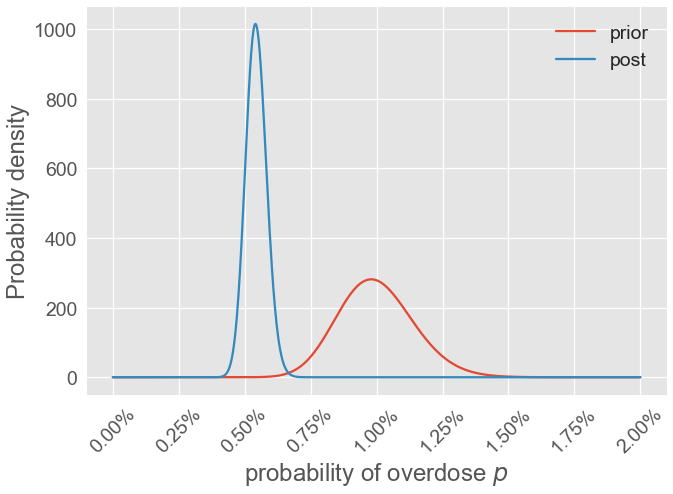

In [208]:

def f(mu, log_sd):
    v = np.exp(log_sd)
    a = ((1 - mu) / v - 1 / mu) * mu ** 2
    b = a * (1 / mu - 1)
    pdf_prior = stats.beta(a,b).pdf(xs)

    a_post = a + D.sum()
    b_post = b + D.size*N - D.sum()

    pdf_post = stats.beta(a_post,b_post).pdf(xs)
    
    # plot posterior and prior
    
    plt.figure();
    plt.plot(xs,pdf_prior,label='prior');
    plt.plot(xs,pdf_post,label='post');
    plt.xlabel('probability of overdose $p$');
    plt.ylabel('Probability density');
    plt.legend();

    #make x-axis pretty
    plt.gca().set_xticklabels(['{0:.2%}'.format(x) for x in plt.gca().get_xticks()],rotation=45);

interactive_plot = interactive(f, mu=(0.001, 0.02,0.001), log_sd=(-20, -5,0.1))
output = interactive_plot.children[-1]
interactive_plot

in general, it's difficult to or even computationally intractable to derive the posterior. Instead we have to find some way of sampling from the posterior. There are two ways of doing this,

0. [Markov Chain Monte Carlo (MCMC)](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo).
    
    One of the cutting edge methods of doing this is through a sampling method called No U-Turn Sampling (NUTS). There are many, many other methods for doing this that exist and there can be many challenges with making sure you're actually sampling from the posterior properly. Even the most sophisticated methods can fail, or become too slow with increasingly complex models.
    
0. Using an approximate method such as [variational Bayes](https://en.wikipedia.org/wiki/Variational_Bayesian_methods).
    
    Many variational methods also exist, including Approximate Differentiation Variational Inference (ADVI). Instead of explicitly sampling from the posterior, these methods construct a known function that can closely approximate the posterior and then optimises the function for the data. We lose some accuracy, but fitting is typically much faster and simpler to perform.

# Probabilistic programming

These are software or libraries that provide ways of constructing probabilistic models in an expressive fashion. They allow for model construction in a similar fashion to how we programmed the example models above: by explictly defining a set of random variables and describing the dependency between them. They will also come with many tools for performing inference, model selection, model fitting and diagnostics for inference methods.

We will be using [Pymc3](https://pymc3.readthedocs.io/en/latest/) here. Other probabilistic programming languages include (in no particular order):

* [Edward](http://edwardlib.org)
    Built on the graph computation language Tensorflow. Seems to be more geared towards deep learning type models.    
* [Stan](https://mc-stan.org)
    This is actually an independent language and so stan models can be written in both `Python` and `R` and many other languages. Mature project developed from Columbia University. 
* [Pyro](http://pyro.ai)
    Open-source library originally developed by Uber. Built in PyTorch (another graph computation language). Still in Beta release. 
    
There are pros and cons to each of these languages. Most have the same set of features built in and so a lot of the decision as to which to go with comes down to stylistic choice. Lots of example code exists for both [Pymc3](https://pymc3.readthedocs.io/en/latest/) and [Stan](https://mc-stan.org), and less so for [Pyro](http://pyro.ai) and [Edward](http://edwardlib.org) so I would consider choosing either of the former two.

## First model with Pymc3

___

![Pymc3 logo](https://cdn.rawgit.com/pymc-devs/pymc3/master/docs/logos/svg/PyMC3_banner.svg)
___

Let's re-create our simple fixed overdose rate model above as a pymc3 model. As a reminder we have a at-risk population of size $N$, which is normally distributed with mean $\mu_N=100000$, and standard deviation $\sigma_N=1000$. A probability of an overdose in a given month is $p$, which is beta distributed with shapes $\alpha_p=1$ and $\beta_p=99$. The number of overdoses in a month $x_t$ is binomially distributed with prevalence $p$ and population $N$.

In [365]:
# define number of months and number of samples
n_months = 12
n_samples = 1000

# define prior for population size
N_mean,N_sd = 10000,1000

# define prior for probability of an overdose
p_alpha,p_beta = 1,99

# instantiate model
model = pm.Model()

# create elements of the model
with model:
    # define population size random variable. PyMC3 needs a label for the RV as the first value.
    N = pm.Normal('N',mu=N_mean, sd=N_sd)
    
    # define population prevalence
    p = pm.Beta('p',alpha=p_alpha,beta=p_beta)

    # generate data (we assume we haven't observed any data so far to draw from the prior)
    x = pm.Binomial('x',n=N,p=p,shape=n_months,observed=np.array([]))


### Generate samples without data

We begin by generating samples wihout data. The is the same as drawing samples from the prior. we use a slice sampler to accomplish this, in more recent versions of pymc3 there is a convenience method called `sample_prior` to do this.

In [366]:
with model:
    # generate samples using a slice sampler
    prior_trace = pm.sample(1000,step=pm.Slice())

100%|██████████| 1000/1000 [00:01<00:00, 874.56it/s]


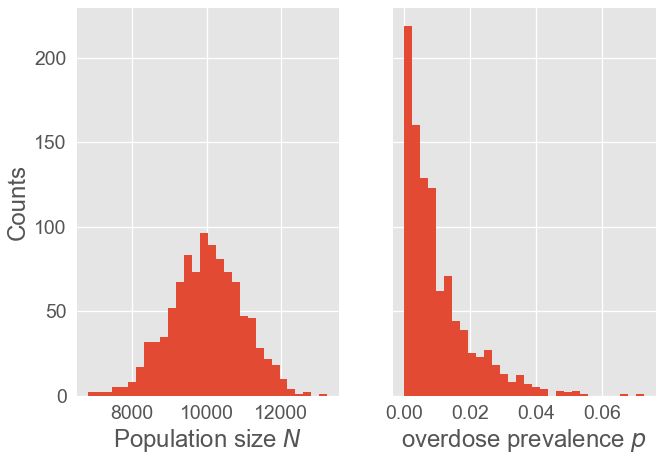

In [367]:
# plot data
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1.hist(prior_trace['N'],bins=30);
ax1.set_ylabel('Counts');
ax1.set_xlabel('Population size $N$');

ax2.hist(prior_trace['p'],bins=30);
ax2.set_xlabel('overdose prevalence $p$');

### Generating a sample of the overdoses

You'll notice above that we don't have any samples of the overdoses themselves. This is because we declared them as being observed, so they are not part of the prior, but part of the likelihood. In general we want to try and avoid discrete distributions that aren't observed if at all possible as they can be notoriously difficult to sample. We can still generate samples of this using the `sample_ppc` method.

In [370]:
with model:
    prior_ppc = pm.sample_ppc(prior_trace)

100%|██████████| 1000/1000 [00:06<00:00, 163.02it/s]


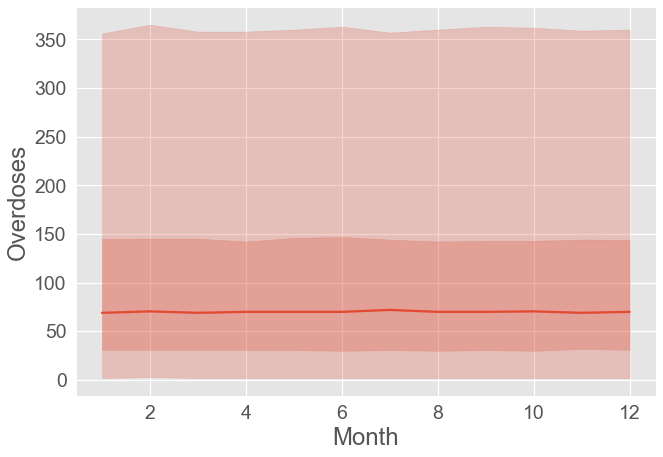

In [371]:
# plot the overdoses

plot_data_timeseries(prior_ppc['x'])

### Fitting to data

The previous model included no data on the number of overdoses in each month. Let's now assume we do have data for the twelve months $D = (88, 115,  93, 145, 154, 134, 144, 141, 170, 136, 131, 147)$ and use this data in the likelihood to sample the posterior. We use the same code as above and change the `observed` keyword in the overdoses to include the data,

In [372]:
# Define data
D = np.array([88, 115,  93, 145, 154, 134, 144, 141, 170, 136, 131, 147])

# instantiate model
model = pm.Model()

# create elements of the model
with model:
    # define population size random variable. PyMC3 needs a label for the RV as the first value.
    N = pm.Normal('N',mu=N_mean, sd=N_sd)
    
    # define population prevalence
    p = pm.Beta('p',alpha=p_alpha,beta=p_beta)

    # generate data (we assume we haven't observed any data so far to draw from the prior)
    x = pm.Binomial('x',n=N,p=p,shape=n_months,observed=D)

In [373]:
# generate trace of posterior
with model:
    # generate samples using a slice sampler
    posterior_trace = pm.sample(1000,step=pm.Slice())

100%|██████████| 1000/1000 [00:01<00:00, 723.36it/s]


In [374]:
# sample the observed random variables (overdoses)
with model:
    posterior_ppc = pm.sample_ppc(posterior_trace)

100%|██████████| 1000/1000 [00:06<00:00, 158.05it/s]


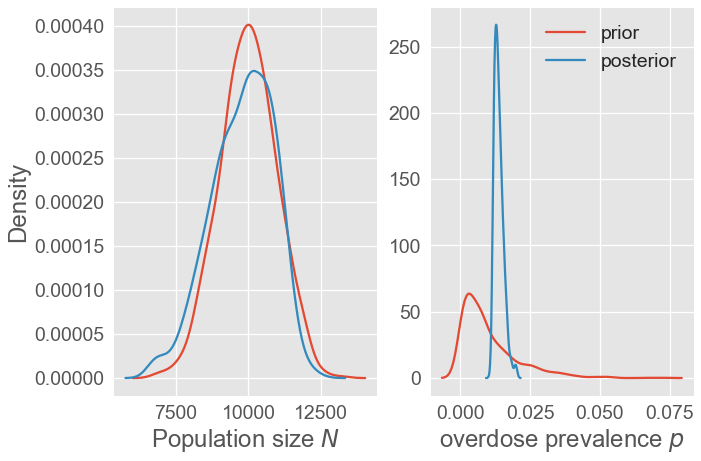

In [375]:
# compare prior and posterior parameters
f, (ax1, ax2) = plt.subplots(1, 2, sharey=False)

sns.kdeplot(prior_trace['N'],ax=ax1);
sns.kdeplot(posterior_trace['N'],ax=ax1);
ax1.set_ylabel('Density');
ax1.set_xlabel('Population size $N$');

sns.kdeplot(prior_trace['p'],ax=ax2,label='prior');
sns.kdeplot(posterior_trace['p'],ax=ax2,label='posterior');
ax2.set_xlabel('overdose prevalence $p$');
ax2.legend();

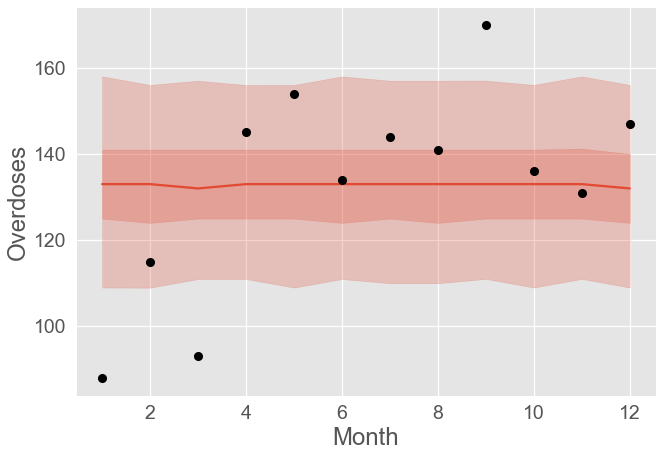

In [376]:
# plot the overdoses and compare to data.
plot_data_timeseries(posterior_ppc['x'])
plt.plot(np.arange(1,n_months+1),D,'ko');

## Variational Bayes

In [377]:
with model:
    v_params = pm.variational.advi(n=100000)
    
with model:
    variational_trace = pm.variational.sample_vp(v_params, draws=1000)

Average ELBO = -70.724: 100%|██████████| 100000/100000 [00:08<00:00, 12378.15it/s]
Finished [100%]: Average ELBO = -70.706
100%|██████████| 1000/1000 [00:00<00:00, 7938.45it/s]


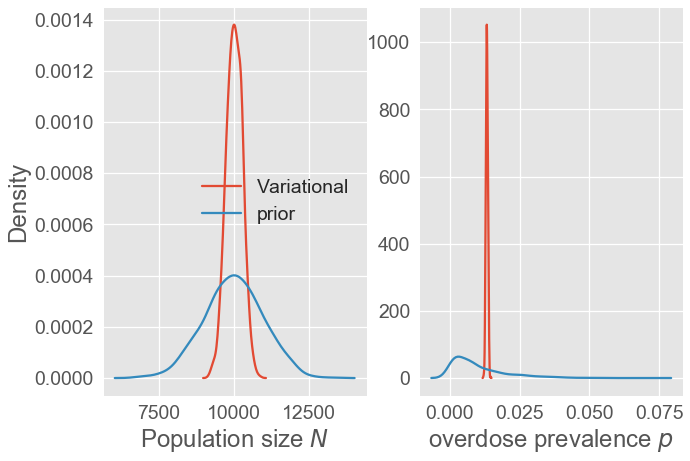

In [380]:
# compare prior and posterior parameters
f, (ax1, ax2) = plt.subplots(1, 2, sharey=False)

sns.kdeplot(variational_trace['N'],ax=ax1,label='Variational');
sns.kdeplot(prior_trace['N'],ax=ax1,label='prior');
ax1.set_ylabel('Density');
ax1.set_xlabel('Population size $N$');
ax1.legend();

sns.kdeplot(variational_trace['p'], ax=ax2);
sns.kdeplot(prior_trace['p'], ax=ax2);
ax2.set_xlabel('overdose prevalence $p$');

In [381]:
with model:
    variational_ppc = pm.sample_ppc(variational_trace)

100%|██████████| 1000/1000 [00:06<00:00, 164.93it/s]


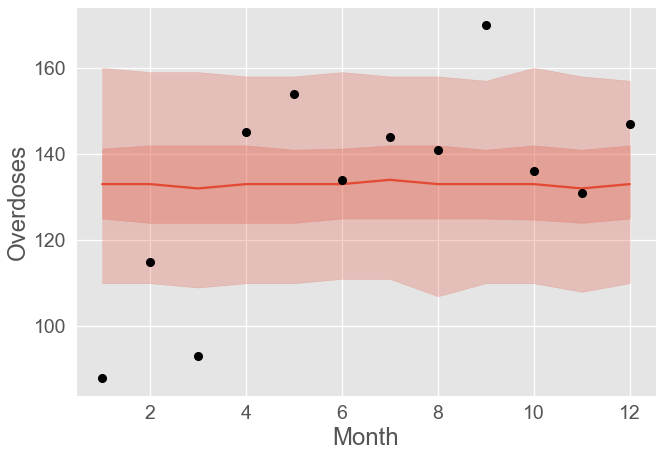

In [382]:
# plot overdose ppc and data
plot_data_timeseries(variational_ppc['x']);
plt.plot(np.arange(1,n_months+1),D,'ko');

Notice that although the uncertainty in the outcome measures is similar, the uncertainty in the parameters is less. This is one of the drawbacks of a variational approach, although it does make model fitting much faster.

### Adding in time variation

Although the model captures the average behaviour, it currently doesn't capture time-varation in the number of overdoses. We can extend the model as before by using the pymc3 `GaussianRandomWalk` class. We'll wrap the model inside of a method to make it easier to switch between the prior and posterior and change some of the hyper-parameters.

In [406]:
def create_timeseries_model(N_mean = 10000, N_sd = 1000, 
                            p0 = 0.01,
                            mu_w=0.0, sigma_w = 0.1,
                            overdoses=None):
    """
    Create pymc3 time-series overdose model
    
    Parameters
    ----------
    N_mean : float
        mean of population size
    N_sd : float
        standard deviation of population size
    p0 : float
        initial prevalence of overdoses
    mu_w : float
        drift for overdose random walk
    sd_w : float
        variance for overdose random walk
    overdoses : numpy array
        overdose data. empty array is sampling from prior
    
    Returns
    -------
    
    Pymc3 model
    
    """
    
    # instantiate model
    model = pm.Model()

    # create elements of the model
    with model:
        # define population size random variable. PyMC3 needs a label for the RV as the first value.
        N = pm.Normal('N',mu=N_mean, sd=N_sd)

        # define random walk process
        w = GaussianRandomWalk('w',mu=mu_w, sd=sigma_w, shape=n_months, init=pm.Normal.dist(mu=logit(p0), sd=0.1))
        
        # convert random walk into probability
        p = pm.Deterministic('p',pm.math.invlogit(w))

        # generate data (we assume we haven't observed any data so far to draw from the prior)
        if overdoses is not None:
            x = pm.Binomial('x',n=tt.cast(N, 'int64'),p=p,shape=n_months,observed=overdoses)
    
    return model

In [407]:
# instantiate model
model = create_timeseries_model()

In [408]:
# generate trace of prior
with model:
    v_params = pm.variational.advi(n=100000)
    
with model:
    prior_trace = pm.variational.sample_vp(v_params, draws=1000)



  0%|          | 0/100000 [00:00<?, ?it/s]

  1%|▏         | 1333/100000 [00:00<00:07, 13229.46it/s]

  3%|▎         | 2961/100000 [00:00<00:06, 14733.77it/s]

  5%|▍         | 4534/100000 [00:00<00:06, 15059.48it/s]

  6%|▌         | 6153/100000 [00:00<00:06, 15348.74it/s]

  8%|▊         | 7745/100000 [00:00<00:05, 15461.31it/s]

  9%|▉         | 9376/100000 [00:00<00:05, 15602.07it/s]

Average ELBO = -892.52:   9%|▉         | 9376/100000 [00:00<00:06, 14404.45it/s]

Average ELBO = -892.52:  11%|█         | 10784/100000 [00:00<00:05, 15211.64it/s]

Average ELBO = -892.52:  12%|█▏        | 12203/100000 [00:00<00:05, 15082.10it/s]

Average ELBO = -892.52:  14%|█▎        | 13701/100000 [00:00<00:05, 15074.20it/s]

Average ELBO = -892.52:  15%|█▌        | 15234/100000 [00:01<00:05, 15098.66it/s]

Average ELBO = -892.52:  17%|█▋        | 16689/100000 [00:01<00:05, 14887.04it/s]

Average ELBO = -892.52:  18%|█▊        | 18214/100000 [00:01<00:05, 14915.58it/s]

Average ELBO = -892.52:  2

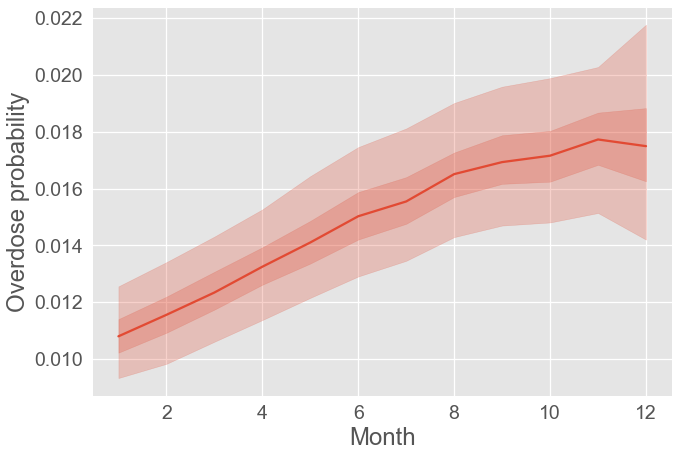

In [409]:
plot_data_timeseries(prior_trace['p'],ylabel='Overdose probability');

In [410]:
# fit model to data
model = create_timeseries_model(overdoses=D)

In [411]:
# generate trace of posterior
with model:
    v_params = pm.variational.advi(n=100000)
    
with model:
    posterior_trace = pm.variational.sample_vp(v_params, draws=1000)



  0%|          | 0/100000 [00:00<?, ?it/s]

  1%|          | 1111/100000 [00:00<00:08, 11028.06it/s]

  2%|▏         | 2305/100000 [00:00<00:08, 11472.17it/s]

  4%|▎         | 3505/100000 [00:00<00:08, 11652.96it/s]

  5%|▍         | 4685/100000 [00:00<00:08, 11687.95it/s]

  6%|▌         | 5663/100000 [00:00<00:08, 11299.17it/s]

  7%|▋         | 6897/100000 [00:00<00:08, 11476.12it/s]

  8%|▊         | 7911/100000 [00:00<00:08, 11281.64it/s]

  9%|▉         | 9138/100000 [00:00<00:07, 11403.33it/s]

Average ELBO = -31,576:   9%|▉         | 9138/100000 [00:00<00:08, 10456.00it/s]

Average ELBO = -31,576:  10%|█         | 10216/100000 [00:00<00:07, 11303.36it/s]

Average ELBO = -31,576:  11%|█▏        | 11287/100000 [00:01<00:07, 11225.47it/s]

Average ELBO = -31,576:  12%|█▏        | 12497/100000 [00:01<00:07, 11304.66it/s]

Average ELBO = -31,576:  14%|█▎        | 13636/100000 [00:01<00:07, 11311.48it/s]

Average ELBO = -31,576:  15%|█▍        | 14892/100000 [00:01<00:07, 11405.67

Average ELBO = -64.84:  94%|█████████▎| 93743/100000 [00:09<00:00, 10208.36it/s]

Average ELBO = -64.84:  95%|█████████▍| 94866/100000 [00:09<00:00, 10219.27it/s]

Average ELBO = -64.84:  96%|█████████▌| 96124/100000 [00:09<00:00, 10244.40it/s]

Average ELBO = -64.84:  97%|█████████▋| 97488/100000 [00:09<00:00, 10280.25it/s]

Average ELBO = -64.84:  99%|█████████▉| 98803/100000 [00:09<00:00, 10310.22it/s]

Average ELBO = -64.84: 100%|██████████| 100000/100000 [00:09<00:00, 10329.12it/s]Finished [100%]: Average ELBO = -64.876


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 12776.61it/s]

In [412]:
# calculate ppc
with model:
    posterior_ppc = pm.sample_ppc(posterior_trace)



  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 1/1000 [00:00<02:02,  8.13it/s]

  1%|          | 12/1000 [00:00<00:18, 53.24it/s]

  3%|▎         | 28/1000 [00:00<00:11, 84.27it/s]

  4%|▍         | 44/1000 [00:00<00:09, 100.99it/s]

  6%|▌         | 59/1000 [00:00<00:08, 109.43it/s]

  7%|▋         | 71/1000 [00:00<00:08, 111.03it/s]

  8%|▊         | 84/1000 [00:00<00:08, 113.31it/s]

 10%|▉         | 99/1000 [00:00<00:07, 116.49it/s]

 12%|█▏        | 115/1000 [00:00<00:07, 120.66it/s]

 13%|█▎        | 131/1000 [00:01<00:07, 123.94it/s]

 15%|█▍        | 146/1000 [00:01<00:06, 125.77it/s]

 16%|█▌        | 161/1000 [00:01<00:06, 126.82it/s]

 18%|█▊        | 175/1000 [00:01<00:06, 127.55it/s]

 19%|█▉        | 189/1000 [00:01<00:06, 128.16it/s]

 20%|██        | 203/1000 [00:01<00:06, 128.38it/s]

 22%|██▏       | 217/1000 [00:01<00:06, 128.67it/s]

 23%|██▎       | 233/1000 [00:01<00:05, 130.20it/s]

 25%|██▍       | 249/1000 [00:01<00:05, 131.33it/s]

 26%|██▋      

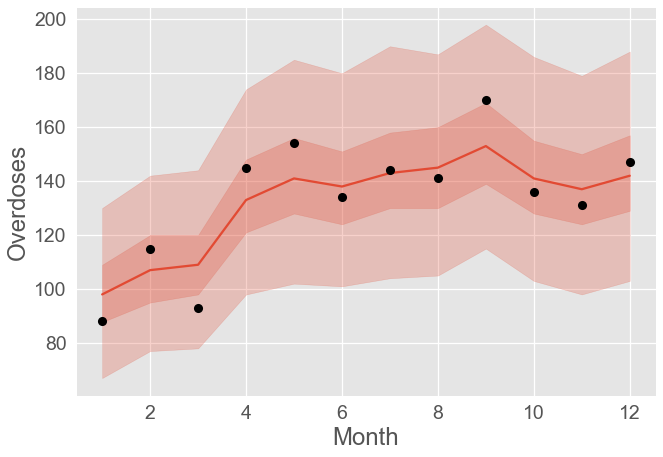

In [413]:
# plot overdose ppc and data
plot_data_timeseries(posterior_ppc['x']);
plt.plot(np.arange(1,n_months+1),D,'ko');

# Sensitivty Analyses

For more information on Bayesian model checking and sensitivity see Chapter 6 of Gelman: [Gelman, Andrew, et al. Bayesian data analysis. 2013.](http://www.stat.columbia.edu/~gelman/bayescomputation/bdachapter6.pdf)

## Leave one out cross validation

Want to know how much each individual dataset influences the results and how predictive the model is of that data. We can use a leave-one-out cross-validation scheme in order to accomplish this. For background on technique see [Sweeting, M. J., et al. *Estimating hepatitis C prevalence in England and Wales by synthesizing evidence from multiple data sources. Assessing data conflict and model fit.* Biostatistics 9.4 (2008): 715-734.](https://doi.org/10.1093/biostatistics/kxn004)

## Subjunctive Bayes

What if we were wrong about one of our priors? We can take a prior (for example, population at risk) and then change either the mean, variance or shape of the prior and then re-run analysis and compare posterior (this is known as subjunctive Bayes)

## Model comparison

Alternative model structures could be likely (e.g. what if probability of death following an overdose is being driven by other external factors?). We can re-create the model using these alternative hypotheses and re-fit to produce a posterior estimate. 

We can then either check:
0. The main model outcome to see if it robust to these changes
0. Use a Bayesian information criterion such as the Deviance Information Criterion (DIC) or Widely-Applicable Information Criterion (WAIC) in order to perform model selection